In [29]:
import pandas as pd
import json
from fileinput import filename
from pyrogram import Client, filters
import os
import datetime
from sklearn.cluster import KMeans
import numpy as np  
#import asyncio
import sys
import service
import Channels
import seaborn as sns
import matplotlib.pyplot as plt
import pyperclip as pyp

#Текущий ноутбук предназначен для аналитики телеграмм каналов:
'''
Таблица сообщений имеет следующие столбцы:
id - id сообщения
text - текст сообщения
views - количество просмотров
all_reactions - суммарное количество всех реакций
<Смайл реакции> - количество реакций конкретного типа
type - тип сообщения, текстовое, с картинкой, опрос
'''

'\nТаблица сообщений имеет следующие столбцы:\nid - id сообщения\ntext - текст сообщения\nviews - количество просмотров\nall_reactions - суммарное количество всех реакций\n<Смайл реакции> - количество реакций конкретного типа\ntype - тип сообщения, текстовое, с картинкой, опрос\n'

In [30]:
#Считываем данные Из файла таблицу
df1 = pd.read_csv("E:/Работа/Zesta/Zesta/result.csv", sep = "*", parse_dates = ["date"])
df1 = df1.iloc[:,1:].fillna(0)
df1 = df1.set_index('date')
#Добавляем столбец с количеством реакций
df1.insert(3, "all_reactions", df1.iloc[:,3:].sum(axis = 1,numeric_only = True))
#Приводим типы столбцов реакций в к Int
d = dict(zip(Channels.REACTIONS + ["all_reactions"], ["int"]*(len(Channels.REACTIONS)+1)))
df1 = df1.astype(d)
#Формируем таблицу реакций
df2 = df1[Channels.REACTIONS]
df2


,👍,👎,😢,🤬,😁,❤
date,,,,,,
2022-07-13 15:09:49,603,7,12,30,104,5
2022-07-13 14:18:56,108,186,138,2665,13,9
2022-07-13 14:12:27,1515,77,65,358,220,10
2022-07-13 14:06:22,110,7,588,9,0,3
2022-07-13 13:47:48,420,56,14,30,106,1786
...,...,...,...,...,...,...
2022-06-08 19:55:56,135,54,10,196,1836,1
2022-06-08 19:45:26,110,24,312,20,817,1
2022-06-08 19:33:12,79,39,8,32,507,1


In [31]:
#Однозначность восприятия новости, столбец one_point = count(самая выраженная реакция)/count(всех остальных реакций)
one_point = df2.T.max()/(df2.T.sum() - df2.T.max())
main_reaction = df2.T.idxmax()
df2.insert(0, "one_point", one_point.T)
df2.insert(0, "main_reaction", main_reaction.T)
df2

,main_reaction,one_point,👍,👎,😢,🤬,😁,❤
date,,,,,,,,
2022-07-13 15:09:49,👍,3.816456,603,7,12,30,104,5
2022-07-13 14:18:56,🤬,5.870044,108,186,138,2665,13,9
2022-07-13 14:12:27,👍,2.075342,1515,77,65,358,220,10
2022-07-13 14:06:22,😢,4.558140,110,7,588,9,0,3
2022-07-13 13:47:48,❤,2.853035,420,56,14,30,106,1786
...,...,...,...,...,...,...,...,...
2022-06-08 19:55:56,😁,4.636364,135,54,10,196,1836,1
2022-06-08 19:45:26,😁,1.749465,110,24,312,20,817,1
2022-06-08 19:33:12,😁,3.188679,79,39,8,32,507,1


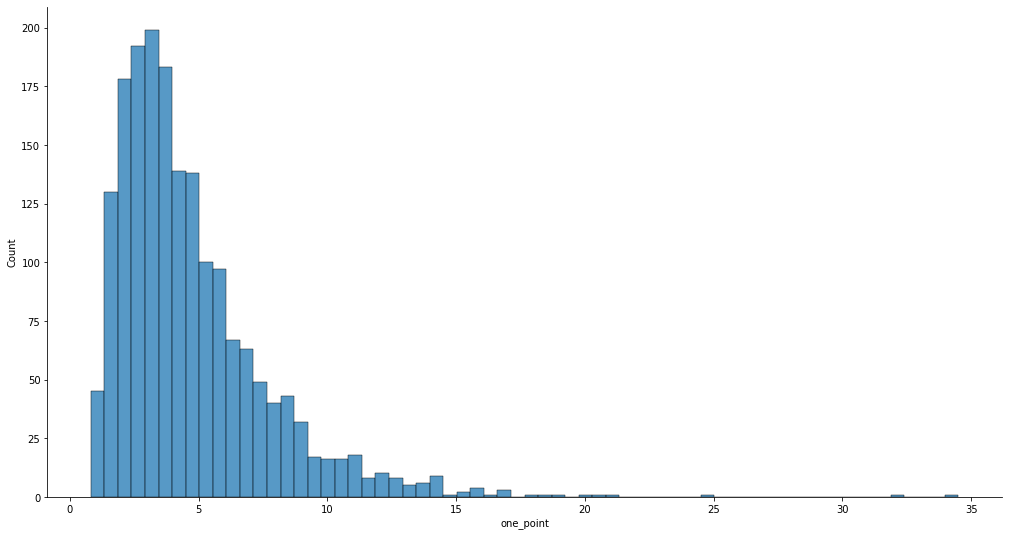

In [32]:
#Строим графики однозначности восприятия новости
grid = sns.displot(data=df2, x = "one_point")
grid.fig.set_figheight(8)
grid.fig.set_figwidth(16)

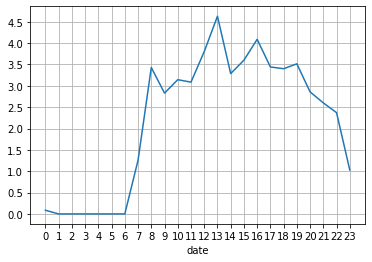

In [33]:
#График среднего количества постов по часам
df3 = df2.resample("1H").size()
ax = df3.groupby(df3.index.hour).mean().plot()
ax.set_xticks(np.arange(0,24,1))
ax.set_yticks(np.arange(0,5,0.5))
ax.grid()

In [34]:
#Формируеим кластеры методом K-Средних
k_maens = KMeans(init="k-means++",n_clusters=15,n_init=30)
k_maens.fit(df1[Channels.REACTIONS])
labels=k_maens.labels_
df1["group number"] = labels
#Количество элементов в кластере
df1["group number"].value_counts()


1     296
4     285
9     250
0     205
2     166
5     133
14    120
3      76
11     70
12     63
7      54
13     47
6      31
8      27
10      5
Name: group number, dtype: int64

In [38]:
#Количество сообщений с самой сильной реакцией
#Количество сообщений с самой слабой реакцией
df1[Channels.REACTIONS].T.idxmax().value_counts(), df1[Channels.REACTIONS].T.idxmin().value_counts()


(👍    572
 😁    512
 🤬    365
 😢    202
 👎    106
 ❤     71
 dtype: int64,
 ❤    858
 🤬    357
 😢    338
 👎    145
 😁    130
 dtype: int64)

In [36]:
#Корреляция количества реакций просмотров от времени нахождения в топе
#Вычисляем столбец нахождения новости в топе
#top_time = df2.index.shift()
df2 = df1.reset_index()
top_time = abs(df2.date - df2.date.shift(1))
top_time

0                  NaT
1      0 days 00:50:53
2      0 days 00:06:29
3      0 days 00:06:05
4      0 days 00:18:34
             ...      
1823   0 days 00:03:47
1824   0 days 00:10:30
1825   0 days 00:12:14
1826   0 days 00:18:24
1827   0 days 00:21:21
Name: date, Length: 1828, dtype: timedelta64[ns]